<a href="https://colab.research.google.com/github/shinnew99/Apziva-Projects/blob/main/Project2-TermDepositMarketing/2nd%263rdLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes for Oct 22, <br>
SVC with SMOTEEN performing very well -> to conclude the 1st part, calculate the impact of the 1st model <br>
<br>
1. 1st layer)
  - One last step to go: Calculate how much time we will be able to save with the company and the % of subscribers we'll be loosing time, for all 40,000 customers to test model with the entire dataset. Here, I cannot use the call related time <br>
  - Consequence: SVC - RandomUnderSampler is the highest performance
<br>
2. 2nd layer) the precision might not be the best metrics, we can focus on f-1 score and find out a problem <br>
I had a problem here: If I train another test and split, the example might be different from that of the 1st layer. So maybe, instead of regenerating the test and train split, use the same test-train split set from the 1st layer but only apply few more columns.
<br>
3. 3rd layer)
- do not use standardscaler, because I will loose interpretability (hard to understand the values)
- try to print out average/ median for each clusters,
featrues I will be print out would be age, durations, jobs for these customers.

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# !pip install optuna

In [33]:
import os
import random

# Warnings
import warnings
warnings.filterwarnings("ignore")

# EDA
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Models
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
# from collections import Counter

# 2nd layer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE  # We use imbalanced-learn library.
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN

# 3rd layer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Validation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [34]:
# Read dataset
df = pd.read_csv('/content/drive/MyDrive/Apziva/TermDepositMarketing/term-deposit-marketing-2020.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


## Models - 3 layers

1. 1st Layer: A layer to predict which of the potential customers we should make calls to (haven't make any calls yet,can't use any call-related features like duration, campaign, month of the call and etc).
2. 2nd Layer: A layer to predict which of the customers we should keep calling to. This means calls have already been made, I can use call-related data, to predict which of the customers we should keep making calls to. (precision for class 1)

They do not directly affect each other
3. 3rd Layer: Train both with the unsupervised model, to understand who those customers are and filtered the non-subscribers. The goal is to segment the subscribers.

In [35]:
seed = random.randint(1000, 9999)
print(seed)

9874


In [36]:
df_copy = df.copy()
df_copy

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


### Train_test_split for Layer2

In [37]:
for col in df.columns:
  print(col, df[col].unique())
  df_copy[col] = pd.factorize(df_copy[col])[0]
# df_copy

X2 = df_copy.drop(columns=['y'])   # The entire dataset is required so just drop Y.
# X2
y2 = df_copy['y']
y2

age [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81]
job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital ['married' 'single' 'divorced']
education ['tertiary' 'secondary' 'unknown' 'primary']
default ['no' 'yes']
balance [  2143     29      2 ...   7222   3402 102127]
housing ['yes' 'no']
loan ['no' 'yes']
contact ['unknown' 'cellular' 'telephone']
day [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']
duration [ 261  151   76 ... 1880 1460 2219]
campaign [ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 38 23 20 29 31 37 30 46 27 58 33 35 34 36 39 44]


,y
0,0
1,0
2,0
3,0
4,0
...,...
39995,0
39996,1
39997,1
39998,0


In [38]:
# Split the dataset
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=seed)

In [39]:
# X2_train is the entire dataset - should I apply the whole df for training
X2_train2 = X2_train[['contact', 'day', 'month', 'duration', 'campaign']]   # these are the campaign related features.
X2_train2

# X2_train2 is the df that only extracts campaign related featuers

,contact,day,month,duration,campaign
18247,1,30,2,215,2
6644,0,16,0,120,0
38897,1,24,0,52,0
25991,1,10,5,100,2
21381,1,24,3,199,5
...,...,...,...,...,...
37924,1,7,0,1020,2
19042,1,0,3,58,3
19921,1,3,3,305,1
22920,1,14,3,386,2


### Reusing the train_test_split from Layer 1

In [40]:
df_copy

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,1,0,0,0,0,0,1,0,0
2,2,2,0,1,0,2,0,1,0,0,0,2,0,0
3,3,3,0,2,0,3,0,0,0,0,0,3,0,0
4,2,4,1,2,0,4,1,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,10,1,0,0,0,412,1,0,1,20,1,100,0,0
39996,33,0,1,0,0,5639,1,0,1,20,1,132,2,1
39997,27,6,2,1,0,455,1,0,1,20,1,305,0,1
39998,35,0,0,0,0,1073,1,0,1,20,1,23,0,0


In [ ]:
[['contact', 'day', 'month', 'duration', 'campaign']]

In [41]:
X1 = df_copy.drop(columns=['duration', 'campaign', 'day', 'month', 'y'])  #Q1. I remove the call-related features, are these correct? The dtypes of each of them are objects and
y1 = df_copy['y']

# Identify categorical columns
categorical_columns = X1.select_dtypes(include=['object']).columns
# print(categorical_columns)
# print(X1)

# Encode categorical features
label_encoder = LabelEncoder()
# print(label_encoder)

In [42]:
for col in categorical_columns:
  X1[col] = label_encoder.fit_transform(X1[col])
  # I can replace to One-hot encoding => it's not always necessary
# print(X1[col])

In [43]:
# Split the dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=seed)

In [44]:
# X1_train_rus
y1_train = y1_train.replace({'no':0, 'yes':1}, inplace=False)
y1_test = y1_test.replace({'no':0, 'yes':1}, inplace=False)

### 2nd Layer: to predict which of the customers we should keep calling to <br>
Few tips to do: <br>
- Utilize the entire dataset with the complete set of all features. (Start from scratch) <br>
- Campaign related features: <br>
predict which of the customers we should keep calling, assuming initial round of calls have already made been -> campaign related features <br>

Similar to the previous steps: start with experimenting few different models.
Maybe try RandomUnderSampler, because it worked well and then experiment with few different models. <br>

This time, the goal is different, predicting which of the customer we should keep calling. Precision for class 1. (which of them precised correctly)

#### Data - RandomUnderSampler


|Data|Model||
|------|---|---|
|RUS (RandomUnderSampler)|RandomForestClassifier|
| |XGBClassifier|
| |SGDClassifier|
| |SVC|
| |LGBMClassifier|
| |DecisionTreeClassifier|


Techniques used in here:
1. RandomForestClassifier / XGBClassifier / SGDClassifier / SVC / LGBMClassifier/ DecisionTreeClassifier
2. SMOTE
3. SMOTE-Tomek
4. SMOTEEN

##### RandomForestClassifier

In [45]:
# 1. Apply RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
X1_train_rus, y1_train_rus = rus.fit_resample(X1_train, y1_train)  # instead of using the entire dataset, apply o
print(y1_train_rus.value_counts())

# Initiate RandomForestClassifier
rfc_rus = RandomForestClassifier(random_state=seed)
rfc_rus.fit(X1_train_rus, y1_train_rus)
y1_pred = rfc_rus.predict(X1_test)
print(f"RandomForestClassifier Applied with RandomUnderSampler: \n", classification_report(y1_test, y1_pred))
# the result is skewed, since the data is imbalanced


# 2. Apply SMOTE (Synthetic Minotiry Oversampling Technique)
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
X1_train_sm, y1_train_sm = sm.fit_resample(X1_train, y1_train)
print(y1_train_sm.value_counts())
# Initiating RandomForestClassifier
rfc_sm = RandomForestClassifier(random_state=seed)
rfc_sm.fit(X1_train_sm, y1_train_sm)
y1_pred_sm = rfc_sm.predict(X1_test)
print(f"RFC-SMOTE Applied: \n", classification_report(y1_test, y1_pred_sm))


# 3. Apply SMOTE-TOMEK
smt = SMOTETomek(sampling_strategy = 'minority', random_state=seed)
X1_train_smt, y1_train_smt = smt.fit_resample(X1_train, y1_train)
print(y1_train_smt.value_counts())
# Initiating RandomForestClassifier
rfc_smt = RandomForestClassifier(random_state=seed)
rfc_smt.fit(X1_train_smt, y1_train_smt)
y1_pred_smt = rfc_smt.predict(X1_test)
print(f"RFC-SMOTE TOMEK Applied: \n", classification_report(y1_test, y1_pred_smt))


# 4. Apply SMOTEEN to balance the classes
smn = SMOTEENN(sampling_strategy = 'minority', random_state=seed)
X1_train_smn, y1_train_smn = smn.fit_resample(X1_train, y1_train)
print(y1_train_smn.value_counts())
# Initiating RandomForestClassifier
rfc_smn = RandomForestClassifier(random_state=seed)
rfc_smn.fit(X1_train_smn, y1_train_smn)
y1_pred_smn = rfc_smn.predict(X1_test)
print(f"RFC-SMOTEEN Applied: \n", classification_report(y1_test, y1_pred_smn))

y
0    2015
1    2015
Name: count, dtype: int64
RandomForestClassifier Applied with RandomUnderSampler: 
               precision    recall  f1-score   support

           0       0.94      0.60      0.73     11119
           1       0.10      0.55      0.17       881

    accuracy                           0.59     12000
   macro avg       0.52      0.57      0.45     12000
weighted avg       0.88      0.59      0.69     12000

y
0    25985
1    25985
Name: count, dtype: int64
RFC-SMOTE Applied: 
               precision    recall  f1-score   support

           0       0.93      0.84      0.89     11119
           1       0.09      0.20      0.13       881

    accuracy                           0.80     12000
   macro avg       0.51      0.52      0.51     12000
weighted avg       0.87      0.80      0.83     12000

y
0    25153
1    25153
Name: count, dtype: int64
RFC-SMOTE TOMEK Applied: 
               precision    recall  f1-score   support

           0       0.93      0.84    

##### XGBClassifier

In [46]:
# 1. Apply RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
X1_train_rus, y1_train_rus = rus.fit_resample(X1_train, y1_train)
print(y1_train_rus.value_counts())

# Initiate XGBClassifier
xgb_rus = XGBClassifier(random_state=seed)
xgb_rus.fit(X1_train_rus, y1_train_rus)
y1_pred = xgb_rus.predict(X1_test)
print(f"XGBClassifier Applied with RandomUnderSampler: \n", classification_report(y1_test, y1_pred))
# the result is skewed, since the data is imbalanced


# 2. Apply SMOTE (Synthetic Minotiry Oversampling Technique)
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
X1_train_sm, y1_train_sm = sm.fit_resample(X1_train, y1_train)
print(y1_train_sm.value_counts())
# Initiating XGBClassifier
xgb_sm = XGBClassifier(random_state=seed)
xgb_sm.fit(X1_train_sm, y1_train_sm)
y1_pred_sm = xgb_sm.predict(X1_test)
print(f"XGB-SMOTE Applied: \n", classification_report(y1_test, y1_pred_sm))


# 3. Apply SMOTE-TOMEK
smt = SMOTETomek(sampling_strategy = 'minority', random_state=seed)
X1_train_smt, y1_train_smt = smt.fit_resample(X1_train, y1_train)
print(y1_train_smt.value_counts())
# Initiating XGBClassifier
xgb_smt = XGBClassifier(random_state=seed)
xgb_smt.fit(X1_train_smt, y1_train_smt)
y1_pred_smt = xgb_smt.predict(X1_test)
print(f"XGB-SMOTE TOMEK Applied: \n", classification_report(y1_test, y1_pred_smt))


# 4. Apply SMOTEEN to balance the classes
smn = SMOTEENN(sampling_strategy = 'minority', random_state=seed)
X1_train_smn, y1_train_smn = smn.fit_resample(X1_train, y1_train)
print(y1_train_smn.value_counts())
# Initiating XGBClassifier
xgb_smn = XGBClassifier(random_state=seed)
xgb_smn.fit(X1_train_smn, y1_train_smn)
y1_pred_smn = xgb_smn.predict(X1_test)
print(f"XGB-SMOTEEN Applied: \n", classification_report(y1_test, y1_pred_smn))

y
0    2015
1    2015
Name: count, dtype: int64
XGBClassifier Applied with RandomUnderSampler: 
               precision    recall  f1-score   support

           0       0.94      0.58      0.71     11119
           1       0.09      0.56      0.16       881

    accuracy                           0.57     12000
   macro avg       0.52      0.57      0.44     12000
weighted avg       0.88      0.57      0.67     12000

y
0    25985
1    25985
Name: count, dtype: int64
XGB-SMOTE Applied: 
               precision    recall  f1-score   support

           0       0.93      0.82      0.87     11119
           1       0.09      0.24      0.13       881

    accuracy                           0.77     12000
   macro avg       0.51      0.53      0.50     12000
weighted avg       0.87      0.77      0.82     12000

y
0    25153
1    25153
Name: count, dtype: int64
XGB-SMOTE TOMEK Applied: 
               precision    recall  f1-score   support

           0       0.93      0.82      0.87   

##### SGDClassifier

In [47]:
# 1. Apply RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
X1_train_rus, y1_train_rus = rus.fit_resample(X1_train, y1_train)
print(y1_train_rus.value_counts())

# Initiate SGDClassifier
sgd_rus = SGDClassifier(random_state=seed)
sgd_rus.fit(X1_train_rus, y1_train_rus)
y1_pred = sgd_rus.predict(X1_test)
print(f"SGDClassifier Applied with RandomUnderSampler: \n", classification_report(y1_test, y1_pred))
# the result is skewed, since the data is imbalanced


# 2. Apply SMOTE (Synthetic Minotiry Oversampling Technique)
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
X1_train_sm, y1_train_sm = sm.fit_resample(X1_train, y1_train)
print(y1_train_sm.value_counts())
# Initiating SGDClassifier
sgd_sm = SGDClassifier(random_state=seed)
sgd_sm.fit(X1_train_sm, y1_train_sm)
y1_pred_sm = sgd_sm.predict(X1_test)
print(f"SGD-SMOTE Applied: \n", classification_report(y1_test, y1_pred_sm))


# 3. Apply SMOTE-TOMEK
smt = SMOTETomek(sampling_strategy = 'minority', random_state=seed)
X1_train_smt, y1_train_smt = smt.fit_resample(X1_train, y1_train)
print(y1_train_smt.value_counts())
# Initiating SGDClassifier
sgd_smt = SGDClassifier(random_state=seed)
sgd_smt.fit(X1_train_smt, y1_train_smt)
y1_pred_smt = sgd_smt.predict(X1_test)
print(f"SGD-SMOTE TOMEK Applied: \n", classification_report(y1_test, y1_pred_smt))


# 4. Apply SMOTEEN to balance the classes
smn = SMOTEENN(sampling_strategy = 'minority', random_state=seed)
X1_train_smn, y1_train_smn = smn.fit_resample(X1_train, y1_train)
print(y1_train_smn.value_counts())
# Initiating SGDClassifier
sgd_smn = SGDClassifier(random_state=seed)
sgd_smn.fit(X1_train_smn, y1_train_smn)
y1_pred_smn = sgd_smn.predict(X1_test)
print(f"SGD-SMOTEEN Applied: \n", classification_report(y1_test, y1_pred_smn))

y
0    2015
1    2015
Name: count, dtype: int64
SGDClassifier Applied with RandomUnderSampler: 
               precision    recall  f1-score   support

           0       0.97      0.02      0.04     11119
           1       0.07      0.99      0.14       881

    accuracy                           0.09     12000
   macro avg       0.52      0.51      0.09     12000
weighted avg       0.90      0.09      0.05     12000

y
0    25985
1    25985
Name: count, dtype: int64
SGD-SMOTE Applied: 
               precision    recall  f1-score   support

           0       0.95      0.18      0.30     11119
           1       0.08      0.87      0.14       881

    accuracy                           0.23     12000
   macro avg       0.51      0.53      0.22     12000
weighted avg       0.88      0.23      0.29     12000

y
0    25153
1    25153
Name: count, dtype: int64
SGD-SMOTE TOMEK Applied: 
               precision    recall  f1-score   support

           0       0.93      0.98      0.95   

##### SVC

In [48]:
# 1. Apply RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
X1_train_rus, y1_train_rus = rus.fit_resample(X1_train, y1_train)
print(y1_train_rus.value_counts())

# Initiate SVC
svc_rus = SVC(random_state=seed)
svc_rus.fit(X1_train_rus, y1_train_rus)
y1_pred = svc_rus.predict(X1_test)
print(f"SVC Applied with RandomUnderSampler: \n", classification_report(y1_test, y1_pred))
# the result is skewed, since the data is imbalanced


# 2. Apply SMOTE (Synthetic Minotiry Oversampling Technique)
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
X1_train_sm, y1_train_sm = sm.fit_resample(X1_train, y1_train)
print(y1_train_sm.value_counts())
# Initiating SGDClassifier
svc_sm = SVC(random_state=seed)
svc_sm.fit(X1_train_sm, y1_train_sm)
y1_pred_sm = svc_sm.predict(X1_test)
print(f"SVC-SMOTE Applied: \n", classification_report(y1_test, y1_pred_sm))


# 3. Apply SMOTE-TOMEK
smt = SMOTETomek(sampling_strategy = 'minority', random_state=seed)
X1_train_smt, y1_train_smt = smt.fit_resample(X1_train, y1_train)
print(y1_train_smt.value_counts())
# Initiating SGDClassifier
svc_smt = SVC(random_state=seed)
svc_smt.fit(X1_train_smt, y1_train_smt)
y1_pred_smt = svc_smt.predict(X1_test)
print(f"SVC-SMOTE TOMEK Applied: \n", classification_report(y1_test, y1_pred_smt))


# 4. Apply SMOTEEN to balance the classes
smn = SMOTEENN(sampling_strategy = 'minority', random_state=seed)
X1_train_smn, y1_train_smn = smn.fit_resample(X1_train, y1_train)
print(y1_train_smn.value_counts())
# Initiating SVC
svc_smn = SVC(random_state=seed)
svc_smn.fit(X1_train_smn, y1_train_smn)
y1_pred_smn = svc_smn.predict(X1_test)
print(f"SVC-SMOTEEN Applied: \n", classification_report(y1_test, y1_pred_smn))

y
0    2015
1    2015
Name: count, dtype: int64
SVC Applied with RandomUnderSampler: 
               precision    recall  f1-score   support

           0       0.94      0.73      0.82     11119
           1       0.10      0.38      0.16       881

    accuracy                           0.71     12000
   macro avg       0.52      0.56      0.49     12000
weighted avg       0.88      0.71      0.77     12000

y
0    25985
1    25985
Name: count, dtype: int64
SVC-SMOTE Applied: 
               precision    recall  f1-score   support

           0       0.94      0.75      0.83     11119
           1       0.10      0.37      0.16       881

    accuracy                           0.72     12000
   macro avg       0.52      0.56      0.50     12000
weighted avg       0.88      0.72      0.78     12000

y
0    25153
1    25153
Name: count, dtype: int64
SVC-SMOTE TOMEK Applied: 
               precision    recall  f1-score   support

           0       0.94      0.75      0.83     11119
  

##### LGBMClassifier

In [49]:
# 1. Apply RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
X1_train_rus, y1_train_rus = rus.fit_resample(X1_train, y1_train)
print(y1_train_rus.value_counts())

# Initiate LGBMClassifier
lgbm_rus = LGBMClassifier(random_state=seed)
lgbm_rus.fit(X1_train_rus, y1_train_rus)
y1_pred = lgbm_rus.predict(X1_test)
print(f"LGBMClassifier Applied with RandomUnderSampler: \n", classification_report(y1_test, y1_pred))
# the result is skewed, since the data is imbalanced


# 2. Apply SMOTE (Synthetic Minotiry Oversampling Technique)
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
X1_train_sm, y1_train_sm = sm.fit_resample(X1_train, y1_train)
print(y1_train_sm.value_counts())
# Initiating LGBMClassifier
lgbm_sm = LGBMClassifier(random_state=seed)
lgbm_sm.fit(X1_train_sm, y1_train_sm)
y1_pred_sm = lgbm_sm.predict(X1_test)
print(f"LGBM-SMOTE Applied: \n", classification_report(y1_test, y1_pred_sm))


# 3. Apply SMOTE-TOMEK
smt = SMOTETomek(sampling_strategy = 'minority', random_state=seed)
X1_train_smt, y1_train_smt = smt.fit_resample(X1_train, y1_train)
print(y1_train_smt.value_counts())
# Initiating LGBMClassifier
lgbm_smt = LGBMClassifier(random_state=seed)
lgbm_smt.fit(X1_train_smt, y1_train_smt)
y1_pred_smt = svc_smt.predict(X1_test)
print(f"LGBM-SMOTE TOMEK Applied: \n", classification_report(y1_test, y1_pred_smt))


# 4. Apply SMOTEEN to balance the classes
smn = SMOTEENN(sampling_strategy = 'minority', random_state=seed)
X1_train_smn, y1_train_smn = smn.fit_resample(X1_train, y1_train)
print(y1_train_smn.value_counts())
# Initiating LGBMClassifier
lgbm_smn = SVC(random_state=seed)
lgbm_smn.fit(X1_train_smn, y1_train_smn)
y1_pred_smn = lgbm_smn.predict(X1_test)
print(f"LGBM-SMOTEEN Applied: \n", classification_report(y1_test, y1_pred_smn))

y
0    2015
1    2015
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 2015, number of negative: 2015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 4030, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBMClassifier Applied with RandomUnderSampler: 
               precision    recall  f1-score   support

           0       0.95      0.59      0.73     11119
           1       0.10      0.58      0.17       881

    accuracy                           0.59     12000
   macro avg       0.52      0.59      0.45     12000
weighted avg       0.88      0.59      0.69     12000

y
0    25985
1    25985
Name: count, dtype: int64
[LightGBM] [Info] Number of

##### DecisionTreeClassifier

In [50]:
# 1. Apply RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
X1_train_rus, y1_train_rus = rus.fit_resample(X1_train, y1_train)
print(y1_train_rus.value_counts())

# Initiate DecisionTreeClassifier
dtc_rus = DecisionTreeClassifier(random_state=seed)
dtc_rus.fit(X1_train_rus, y1_train_rus)
y1_pred = dtc_rus.predict(X1_test)
print(f"DecisionTreeClassifier Applied with RandomUnderSampler: \n", classification_report(y1_test, y1_pred))
# the result is skewed, since the data is imbalanced


# 2. Apply SMOTE (Synthetic Minotiry Oversampling Technique)
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
X1_train_sm, y1_train_sm = sm.fit_resample(X1_train, y1_train)
print(y1_train_sm.value_counts())
# Initiating DTClassifier
dtc_sm = DecisionTreeClassifier(random_state=seed)
dtc_sm.fit(X1_train_sm, y1_train_sm)
y1_pred_sm = dtc_sm.predict(X1_test)
print(f"DTC-SMOTE Applied: \n", classification_report(y1_test, y1_pred_sm))


# 3. Apply SMOTE-TOMEK
smt = SMOTETomek(sampling_strategy = 'minority', random_state=seed)
X1_train_smt, y1_train_smt = smt.fit_resample(X1_train, y1_train)
print(y1_train_smt.value_counts())
# Initiating DTClassifier
dtc_smt = DecisionTreeClassifier(random_state=seed)
dtc_smt.fit(X1_train_smt, y1_train_smt)
y1_pred_smt = dtc_smt.predict(X1_test)
print(f"DTC-SMOTE TOMEK Applied: \n", classification_report(y1_test, y1_pred_smt))


# 4. Apply SMOTEEN to balance the classes
smn = SMOTEENN(sampling_strategy = 'minority', random_state=seed)
X1_train_smn, y1_train_smn = smn.fit_resample(X1_train, y1_train)
print(y1_train_smn.value_counts())
# Initiating DTClassifier
dtc_smn = SVC(random_state=seed)
dtc_smn.fit(X1_train_smn, y1_train_smn)
y1_pred_smn = dtc_smn.predict(X1_test)
print(f"DTC-SMOTEEN Applied: \n", classification_report(y1_test, y1_pred_smn))

y
0    2015
1    2015
Name: count, dtype: int64
DecisionTreeClassifier Applied with RandomUnderSampler: 
               precision    recall  f1-score   support

           0       0.94      0.54      0.68     11119
           1       0.09      0.55      0.15       881

    accuracy                           0.54     12000
   macro avg       0.51      0.54      0.42     12000
weighted avg       0.87      0.54      0.64     12000

y
0    25985
1    25985
Name: count, dtype: int64
DTC-SMOTE Applied: 
               precision    recall  f1-score   support

           0       0.93      0.81      0.87     11119
           1       0.09      0.23      0.13       881

    accuracy                           0.77     12000
   macro avg       0.51      0.52      0.50     12000
weighted avg       0.87      0.77      0.81     12000

y
0    25153
1    25153
Name: count, dtype: int64
DTC-SMOTE TOMEK Applied: 
               precision    recall  f1-score   support

           0       0.93      0.81    

#### Data - RandomOverSampler


|Data|Model||
|------|---|---|
|RUS (RandomUnderSampler)|RandomForestClassifier|
| |XGBClassifier|
| |SGDClassifier|
| |SVC|
| |LGBMClassifier|
| |DecisionTreeClassifier|


Techniques used in here:
1. RandomForestClassifier / XGBClassifier / SGDClassifier / SVC / LGBMClassifier/ DecisionTreeClassifier
2. SMOTE
3. SMOTE-Tomek
4. SMOTEEN

##### RandomForestClassifier

In [51]:
# 1. Apply RandomUnderSampler
ros = RandomOverSampler(sampling_strategy='minority', random_state=seed)
X1_train_ros, y1_train_ros = rus.fit_resample(X1_train, y1_train)
print(y1_train_ros.value_counts())

# Initiate RandomForestClassifier
rfc_ros = RandomForestClassifier(random_state=seed)
rfc_ros.fit(X1_train_ros, y1_train_ros)
y1_pred = rfc_ros.predict(X1_test)
print(f"RandomForestClassifier Applied with RandomUnderSampler: \n", classification_report(y1_test, y1_pred))
# the result is skewed, since the data is imbalanced


# 2. Apply SMOTE (Synthetic Minotiry Oversampling Technique)
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
X1_train_sm, y1_train_sm = sm.fit_resample(X1_train, y1_train)
print(y1_train_sm.value_counts())
# Initiating RandomForestClassifier
rfc_sm = RandomForestClassifier(random_state=seed)
rfc_sm.fit(X1_train_sm, y1_train_sm)
y1_pred_sm = rfc_sm.predict(X1_test)
print(f"RFC-SMOTE Applied: \n", classification_report(y1_test, y1_pred_sm))


# 3. Apply SMOTE-TOMEK
smt = SMOTETomek(sampling_strategy = 'minority', random_state=seed)
X1_train_smt, y1_train_smt = smt.fit_resample(X1_train, y1_train)
print(y1_train_smt.value_counts())
# Initiating RandomForestClassifier
rfc_smt = RandomForestClassifier(random_state=seed)
rfc_smt.fit(X1_train_smt, y1_train_smt)
y1_pred_smt = rfc_smt.predict(X1_test)
print(f"RFC-SMOTE TOMEK Applied: \n", classification_report(y1_test, y1_pred_smt))


# 4. Apply SMOTEEN to balance the classes
smn = SMOTEENN(sampling_strategy = 'minority', random_state=seed)
X1_train_smn, y1_train_smn = smn.fit_resample(X1_train, y1_train)
print(y1_train_smn.value_counts())
# Initiating RandomForestClassifier
rfc_smn = RandomForestClassifier(random_state=seed)
rfc_smn.fit(X1_train_smn, y1_train_smn)
y1_pred_smn = rfc_smn.predict(X1_test)
print(f"RFC-SMOTEEN Applied: \n", classification_report(y1_test, y1_pred_smn))

y
0    2015
1    2015
Name: count, dtype: int64
RandomForestClassifier Applied with RandomUnderSampler: 
               precision    recall  f1-score   support

           0       0.94      0.60      0.73     11119
           1       0.10      0.55      0.17       881

    accuracy                           0.59     12000
   macro avg       0.52      0.57      0.45     12000
weighted avg       0.88      0.59      0.69     12000

y
0    25985
1    25985
Name: count, dtype: int64
RFC-SMOTE Applied: 
               precision    recall  f1-score   support

           0       0.93      0.84      0.89     11119
           1       0.09      0.20      0.13       881

    accuracy                           0.80     12000
   macro avg       0.51      0.52      0.51     12000
weighted avg       0.87      0.80      0.83     12000

y
0    25153
1    25153
Name: count, dtype: int64
RFC-SMOTE TOMEK Applied: 
               precision    recall  f1-score   support

           0       0.93      0.84    

##### XGBClassifier

In [52]:
# 1. Apply RandomUnderSampler
ros = RandomOverSampler(sampling_strategy='minority', random_state=seed)
X1_train_ros, y1_train_ros = ros.fit_resample(X1_train, y1_train)
print(y1_train_ros.value_counts())

# Initiate XGBClassifier
xgb_ros = XGBClassifier(random_state=seed)
xgb_ros.fit(X1_train_ros, y1_train_ros)
y2_pred = xgb_ros.predict(X1_test)
print(f"XGBClassifier Applied with RandomUnderSampler: \n", classification_report(y1_test, y1_pred))
# the result is skewed, since the data is imbalanced


# 2. Apply SMOTE (Synthetic Minotiry Oversampling Technique)
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
X1_train_sm, y1_train_sm = sm.fit_resample(X1_train, y1_train)
print(y1_train_sm.value_counts())
# Initiating XGBClassifier
xgb_sm = XGBClassifier(random_state=seed)
xgb_sm.fit(X1_train_sm, y1_train_sm)
y1_pred_sm = xgb_sm.predict(X1_test)
print(f"XGB-SMOTE Applied: \n", classification_report(y1_test, y1_pred_sm))


# 3. Apply SMOTE-TOMEK
smt = SMOTETomek(sampling_strategy = 'minority', random_state=seed)
X1_train_smt, y1_train_smt = smt.fit_resample(X1_train, y1_train)
print(y1_train_smt.value_counts())
# Initiating XGBClassifier
xgb_smt = XGBClassifier(random_state=seed)
xgb_smt.fit(X1_train_smt, y1_train_smt)
y1_pred_smt = xgb_smt.predict(X1_test)
print(f"RFC-SMOTE TOMEK Applied: \n", classification_report(y1_test, y1_pred_smt))


# 4. Apply SMOTEEN to balance the classes
smn = SMOTEENN(sampling_strategy = 'minority', random_state=seed)
X1_train_smn, y1_train_smn = smn.fit_resample(X1_train, y1_train)
print(y1_train_smn.value_counts())
# Initiating RandomForestClassifier
xgb_smn = XGBClassifier(random_state=seed)
xgb_smn.fit(X1_train_smn, y1_train_smn)
y1_pred_smn = xgb_smn.predict(X1_test)
print(f"RFC-SMOTEEN Applied: \n", classification_report(y1_test, y1_pred_smn))

y
0    25985
1    25985
Name: count, dtype: int64
XGBClassifier Applied with RandomUnderSampler: 
               precision    recall  f1-score   support

           0       0.94      0.60      0.73     11119
           1       0.10      0.55      0.17       881

    accuracy                           0.59     12000
   macro avg       0.52      0.57      0.45     12000
weighted avg       0.88      0.59      0.69     12000

y
0    25985
1    25985
Name: count, dtype: int64
XGB-SMOTE Applied: 
               precision    recall  f1-score   support

           0       0.93      0.82      0.87     11119
           1       0.09      0.24      0.13       881

    accuracy                           0.77     12000
   macro avg       0.51      0.53      0.50     12000
weighted avg       0.87      0.77      0.82     12000

y
0    25153
1    25153
Name: count, dtype: int64
RFC-SMOTE TOMEK Applied: 
               precision    recall  f1-score   support

           0       0.93      0.82      0.87 

##### SGDClassifier

In [53]:
# 1. Apply RandomUnderSampler
ros = RandomOverSampler(sampling_strategy='minority', random_state=seed)
X1_train_ros, y1_train_ros = ros.fit_resample(X1_train, y1_train)
print(y1_train_ros.value_counts())

# Initiate SGDClassifier
sgd_ros = SGDClassifier(random_state=seed)
sgd_ros.fit(X1_train_ros, y1_train_ros)
y1_pred = sgd_ros.predict(X1_test)
print(f"SGDClassifier Applied with RandomOverSampler: \n", classification_report(y1_test, y1_pred))
# the result is skewed, since the data is imbalanced


# 2. Apply SMOTE (Synthetic Minotiry Oversampling Technique)
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
X1_train_sm, y1_train_sm = sm.fit_resample(X1_train, y1_train)
print(y1_train_sm.value_counts())
# Initiating SGDClassifier
sgd_sm = SGDClassifier(random_state=seed)
sgd_sm.fit(X1_train_sm, y1_train_sm)
y1_pred_sm = sgd_sm.predict(X1_test)
print(f"SGD-SMOTE Applied: \n", classification_report(y1_test, y1_pred_sm))


# 3. Apply SMOTE-TOMEK
smt = SMOTETomek(sampling_strategy = 'minority', random_state=seed)
X1_train_smt, y1_train_smt = smt.fit_resample(X1_train, y1_train)
print(y1_train_smt.value_counts())
# Initiating SGDClassifier
sgd_smt = SGDClassifier(random_state=seed)
sgd_smt.fit(X1_train_smt, y1_train_smt)
y2_pred_smt = sgd_smt.predict(X1_test)
print(f"SGD-SMOTE TOMEK Applied: \n", classification_report(y1_test, y1_pred_smt))


# 4. Apply SMOTEEN to balance the classes
smn = SMOTEENN(sampling_strategy = 'minority', random_state=seed)
X1_train_smn, y1_train_smn = smn.fit_resample(X1_train, y1_train)
print(y1_train_smn.value_counts())
# Initiating SGDClassifier
sgd_smn = SGDClassifier(random_state=seed)
sgd_smn.fit(X1_train_smn, y1_train_smn)
y1_pred_smn = sgd_smn.predict(X1_test)
print(f"SGD-SMOTEEN Applied: \n", classification_report(y1_test, y1_pred_smn))

y
0    25985
1    25985
Name: count, dtype: int64
SGDClassifier Applied with RandomOverSampler: 
               precision    recall  f1-score   support

           0       0.95      0.23      0.37     11119
           1       0.08      0.85      0.15       881

    accuracy                           0.27     12000
   macro avg       0.52      0.54      0.26     12000
weighted avg       0.89      0.27      0.35     12000

y
0    25985
1    25985
Name: count, dtype: int64
SGD-SMOTE Applied: 
               precision    recall  f1-score   support

           0       0.95      0.18      0.30     11119
           1       0.08      0.87      0.14       881

    accuracy                           0.23     12000
   macro avg       0.51      0.53      0.22     12000
weighted avg       0.88      0.23      0.29     12000

y
0    25153
1    25153
Name: count, dtype: int64
SGD-SMOTE TOMEK Applied: 
               precision    recall  f1-score   support

           0       0.93      0.82      0.87  

##### SVC

In [54]:
# 1. Apply RandomUnderSampler
ros = RandomOverSampler(sampling_strategy='minority', random_state=seed)
X1_train_ros, y1_train_ros = ros.fit_resample(X1_train, y1_train)
print(y1_train_ros.value_counts())

# Initiate SVC
svc_ros = SVC(random_state=seed)
svc_ros.fit(X1_train_ros, y1_train_ros)
y1_pred = svc_ros.predict(X1_test)
print(f"SVC Applied with RandomOverSampler: \n", classification_report(y1_test, y1_pred))
# the result is skewed, since the data is imbalanced


# 2. Apply SMOTE (Synthetic Minotiry Oversampling Technique)
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
X1_train_sm, y1_train_sm = sm.fit_resample(X1_train, y1_train)
print(y1_train_sm.value_counts())
# Initiating SGDClassifier
svc_sm = SVC(random_state=seed)
svc_sm.fit(X1_train_sm, y1_train_sm)
y1_pred_sm = svc_sm.predict(X1_test)
print(f"SVC-SMOTE Applied: \n", classification_report(y1_test, y1_pred_sm))


# 3. Apply SMOTE-TOMEK
smt = SMOTETomek(sampling_strategy = 'minority', random_state=seed)
X1_train_smt, y1_train_smt = smt.fit_resample(X1_train, y1_train)
print(y1_train_smt.value_counts())
# Initiating SVC
svc_smt = SVC(random_state=seed)
svc_smt.fit(X1_train_smt, y1_train_smt)
y1_pred_smt = svc_smt.predict(X1_test)
print(f"SVC-SMOTE TOMEK Applied: \n", classification_report(y1_test, y1_pred_smt))


# 4. Apply SMOTEEN to balance the classes
smn = SMOTEENN(sampling_strategy = 'minority', random_state=seed)
X1_train_smn, y1_train_smn = smn.fit_resample(X1_train, y1_train)
print(y1_train_smn.value_counts())
# Initiating SVC
svc_smn = SVC(random_state=seed)
svc_smn.fit(X1_train_smn, y1_train_smn)
y1_pred_smn = svc_smn.predict(X1_test)
print(f"SVC-SMOTEEN Applied: \n", classification_report(y1_test, y1_pred_smn))


# Somthing's wrong here:
# For the 1st layer, I had a higher perforamcne with fewer features, but here, I train with many columns but!! having a lower performancce.
# I should detect why - probably small mistakes!

y
0    25985
1    25985
Name: count, dtype: int64
SVC Applied with RandomOverSampler: 
               precision    recall  f1-score   support

           0       0.94      0.75      0.84     11119
           1       0.10      0.36      0.16       881

    accuracy                           0.73     12000
   macro avg       0.52      0.56      0.50     12000
weighted avg       0.88      0.73      0.79     12000

y
0    25985
1    25985
Name: count, dtype: int64
SVC-SMOTE Applied: 
               precision    recall  f1-score   support

           0       0.94      0.75      0.83     11119
           1       0.10      0.37      0.16       881

    accuracy                           0.72     12000
   macro avg       0.52      0.56      0.50     12000
weighted avg       0.88      0.72      0.78     12000

y
0    25153
1    25153
Name: count, dtype: int64
SVC-SMOTE TOMEK Applied: 
               precision    recall  f1-score   support

           0       0.94      0.75      0.83     11119
 

##### LGBMClassifier

In [55]:
# 1. Apply RandomUnderSampler
ros = RandomOverSampler(sampling_strategy='minority', random_state=seed)
X1_train_ros, y1_train_ros = ros.fit_resample(X1_train, y1_train)
print(y1_train_ros.value_counts())

# Initiate LGBMClassifier
lgbm_ros = LGBMClassifier(random_state=seed)
lgbm_ros.fit(X1_train_ros, y1_train_ros)
y1_pred = lgbm_ros.predict(X1_test)
print(f"LGBMClassifier Applied with RandomOverSampler: \n", classification_report(y1_test, y1_pred))
# the result is skewed, since the data is imbalanced


# 2. Apply SMOTE (Synthetic Minotiry Oversampling Technique)
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
X1_train_sm, y1_train_sm = sm.fit_resample(X1_train, y1_train)
print(y1_train_sm.value_counts())
# Initiating LGBMClassifier
lgbm_sm = LGBMClassifier(random_state=seed)
lgbm_sm.fit(X1_train_sm, y1_train_sm)
y2_pred_sm = lgbm_sm.predict(X1_test)
print(f"LGBM-SMOTE Applied: \n", classification_report(y1_test, y1_pred_sm))


# 3. Apply SMOTE-TOMEK
smt = SMOTETomek(sampling_strategy = 'minority', random_state=seed)
X1_train_smt, y1_train_smt = smt.fit_resample(X1_train, y1_train)
print(y1_train_smt.value_counts())
# Initiating LGBM
lgbm_smt = SVC(random_state=seed)
lgbm_smt.fit(X1_train_smt, y1_train_smt)
y1_pred_smt = lgbm_smt.predict(X1_test)
print(f"LGBM-SMOTE TOMEK Applied: \n", classification_report(y1_test, y1_pred_smt))


# 4. Apply SMOTEEN to balance the classes
smn = SMOTEENN(sampling_strategy = 'minority', random_state=seed)
X1_train_smn, y1_train_smn = smn.fit_resample(X1_train, y1_train)
print(y1_train_smn.value_counts())
# Initiating LGBM
lgbm_smn = LGBMClassifier(random_state=seed)
lgbm_smn.fit(X1_train_smn, y1_train_smn)
y1_pred_smn = svc_smn.predict(X1_test)
print(f"LGBM-SMOTEEN Applied: \n", classification_report(y1_test, y1_pred_smn))

y
0    25985
1    25985
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 25985, number of negative: 25985
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 51970, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBMClassifier Applied with RandomOverSampler: 
               precision    recall  f1-score   support

           0       0.95      0.71      0.81     11119
           1       0.12      0.48      0.19       881

    accuracy                           0.69     12000
   macro avg       0.53      0.60      0.50     12000
weighted avg       0.88      0.69      0.77     12000

y
0    25985
1    25985
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 25985, number of negative: 25985
[LightGBM] [Info

##### DecisionTreeClassifier

In [56]:
# 1. Apply RandomUnderSampler
ros = RandomOverSampler(sampling_strategy='minority', random_state=seed)
X1_train_ros, y1_train_ros = ros.fit_resample(X1_train, y1_train)
print(y1_train_ros.value_counts())

# Initiate DecisionTreeClassifier
dtc_ros = DecisionTreeClassifier(random_state=seed)
dtc_ros.fit(X1_train_ros, y1_train_ros)
y1_pred = dtc_ros.predict(X1_test)
print(f"DecisionTreeClassifier Applied with RandomOverSampler: \n", classification_report(y1_test, y1_pred))
# the result is skewed, since the data is imbalanced


# 2. Apply SMOTE (Synthetic Minotiry Oversampling Technique)
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
X1_train_sm, y1_train_sm = sm.fit_resample(X1_train, y1_train)
print(y1_train_sm.value_counts())
# Initiating DecisionTreeClassifier
dtc_sm = DecisionTreeClassifier(random_state=seed)
dtc_sm.fit(X1_train_sm, y1_train_sm)
y1_pred_sm = dtc_sm.predict(X1_test)
print(f"DTC-SMOTE Applied: \n", classification_report(y1_test, y1_pred_sm))


# 3. Apply SMOTE-TOMEK
smt = SMOTETomek(sampling_strategy = 'minority', random_state=seed)
X1_train_smt, y1_train_smt = smt.fit_resample(X1_train, y1_train)
print(y1_train_smt.value_counts())
# Initiating DecisionTreeClassifier
dtc_smt = DecisionTreeClassifier(random_state=seed)
dtc_smt.fit(X1_train_smt, y1_train_smt)
y1_pred_smt = dtc_smt.predict(X1_test)
print(f"LGBM-SMOTE TOMEK Applied: \n", classification_report(y1_test, y1_pred_smt))


# 4. Apply SMOTEEN to balance the classes
smn = SMOTEENN(sampling_strategy = 'minority', random_state=seed)
X1_train_smn, y1_train_smn = smn.fit_resample(X1_train, y1_train)
print(y1_train_smn.value_counts())
# Initiating DTC
dtc_smn = DecisionTreeClassifier(random_state=seed)
dtc_smn.fit(X1_train_smn, y1_train_smn)
y1_pred_smn = dtc_smn.predict(X1_test)
print(f"DTC-SMOTEEN Applied: \n", classification_report(y1_test, y1_pred_smn))

y
0    25985
1    25985
Name: count, dtype: int64
DecisionTreeClassifier Applied with RandomOverSampler: 
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     11119
           1       0.13      0.15      0.14       881

    accuracy                           0.87     12000
   macro avg       0.53      0.53      0.53     12000
weighted avg       0.87      0.87      0.87     12000

y
0    25985
1    25985
Name: count, dtype: int64
DTC-SMOTE Applied: 
               precision    recall  f1-score   support

           0       0.93      0.81      0.87     11119
           1       0.09      0.23      0.13       881

    accuracy                           0.77     12000
   macro avg       0.51      0.52      0.50     12000
weighted avg       0.87      0.77      0.81     12000

y
0    25153
1    25153
Name: count, dtype: int64
LGBM-SMOTE TOMEK Applied: 
               precision    recall  f1-score   support

           0       0.93      0.81  

### 3rd Layer: Training, help the company understand who those customers are
- filter out non subscribers and only work with subscribers
- unsupversied training K-means and hierarchical clustering to identify customer segments

#### K-Means and PCA

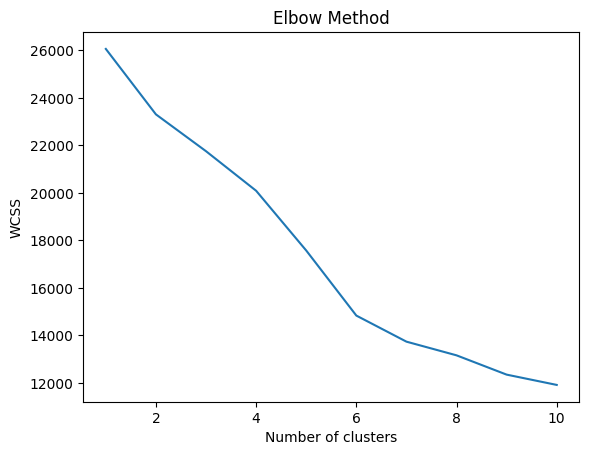

Cluster
2    1136
0     982
1     778
Name: count, dtype: int64
               age       job   marital  education   default      balance  \
Cluster                                                                    
0        21.710794  4.279022  0.258656   0.919552  0.005092  2087.423625   
1        18.789203  1.885604  1.430591   0.507712  0.024422  2347.143959   
2        18.306338  3.869718  0.389085   1.206866  0.022007  1550.175176   

          housing      loan   contact        day     month    duration  \
Cluster                                                                  
0        0.981670  0.081466  1.037678  14.948065  5.113035  607.715886   
1        0.564267  0.123393  0.933162  13.832905  4.183805  661.209512   
2        0.025528  0.179577  0.721831  12.958627  2.546655  725.455106   

         campaign    y  
Cluster                 
0        1.561100  1.0  
1        1.430591  1.0  
2        1.443662  1.0  


In [57]:
# Step1: Filter the data to include only subscribers.
subscribers_data = df_copy[df_copy['y']==1]  # Assuming 'y' is the column indicating subscribers
# subscribers_data  # 2896


# Step 2: Select relevant features for clustering
# Exclude 'y' and other call-related features like 'duration', 'campaign', etc.
clustering_features = subscribers_data.drop(columns=['y', 'duration', 'campaign', 'day', 'month'])
# clustering_features  # 2896


# Step 3: Scale the data
# StandardScaler = StandardScaler()
scaled_features = StandardScaler.fit_transform(clustering_features)
# scaled_features

# Step 4: Apply KMeans Clustering
# Determine optimal number of clusters using the elbow method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=seed)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Choose the number of clusters (e.g., 3) based on the elbow plot
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=seed)
subscribers_data['Cluster'] = kmeans.fit_predict(scaled_features)


# Step 5: Analyze and interpret the clusters
# For example, checking the distribution of each cluster:
print(subscribers_data['Cluster'].value_counts())

# Or calculating the mean values of each feature within clusters to understand characteristics:
cluster_summary = subscribers_data.groupby('Cluster').mean()
# For Ordinal Feature:
# Job/Education etc.. Feature: try to calculate the most common and include that separately unless it makse hard for me to interpret the data
print(cluster_summary)

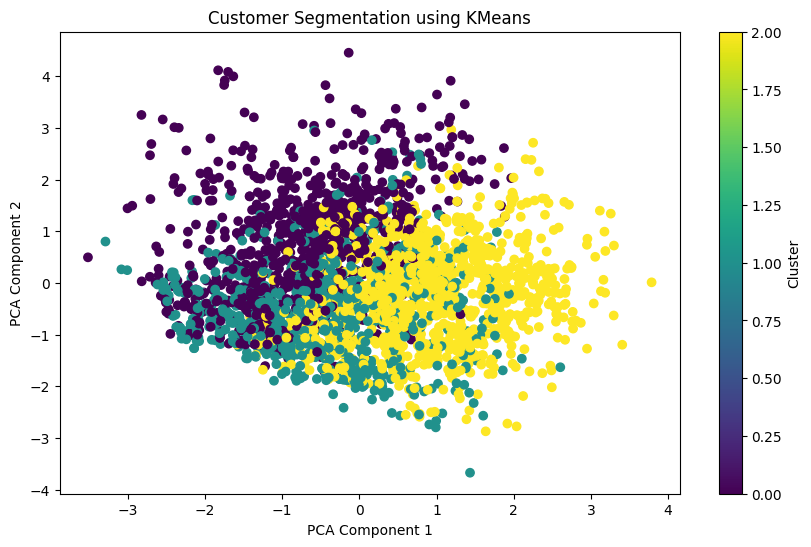

In [58]:
# If needed, visualize the clusters using PCA (Principal Component Analysis) for better understanding:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=subscribers_data['Cluster'], cmap='viridis')
plt.title('Customer Segmentation using KMeans')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

#### K-Means

In [59]:
# Step 1: Filter the data to include only subscribers
subscribers_data = df_copy[df_copy['y'] == 1]  # Assuming 'y' is the column indicating subscription status

# Step 2: Select relevant features for clustering
# Exclude 'y' and other call-related features like 'duration', 'campaign', 'day', 'month'
clustering_features = subscribers_data.drop(columns=['y', 'duration', 'campaign', 'day', 'month'])

# Step 3: Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Step 4: Apply KMeans Clustering
# Determine the optimal number of clusters using the elbow method (optional)
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Choose the number of clusters (e.g., 3) based on the elbow plot
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
subscribers_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Step 5: Analyze and interpret the clusters
print(subscribers_data['Cluster'].value_counts())

# Calculate the mean values of each feature within clusters to understand characteristics
cluster_summary = subscribers_data.groupby('Cluster').mean()
print(cluster_summary)

TypeError: 'StandardScaler' object is not callable

#### Hierarhical Clustering

In [ ]:
# Step 1: Filter the data to include only subscribers
subscribers_data = df_copy[df_copy['y'] == 1]  # Assuming 'y' is the column indicating subscription status

# Step 2: Select relevant features for clustering
# Exclude 'y' and other call-related features like 'duration', 'campaign', 'day', 'month'
clustering_features = subscribers_data.drop(columns=['y', 'duration', 'campaign', 'day', 'month'])

# Step 3: Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Step 4: Apply Hierarchical Clustering
# Create the linkage matrix using 'ward' method
linked = linkage(scaled_features, method='ward')

# Plot the dendrogram to determine the optimal number of clusters
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

# Cut the dendrogram at a point to define clusters, e.g., 3 clusters
optimal_clusters = 3
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
subscribers_data['Cluster'] = hierarchical.fit_predict(scaled_features)

# Step 5: Analyze and interpret the clusters
print(subscribers_data['Cluster'].value_counts())
# But I don't know what each values means

# Calculate the mean values of each feature within clusters to understand characteristics
cluster_summary = subscribers_data.groupby('Cluster').mean()
print(cluster_summary)

In [ ]:
# Step 1: Filter out non-subscribers (only keep customers who have purchased the product)
subscribers_df = df_copy[df_copy['y'] == 1]

# Step 2: Select features for clustering (you can adjust these based on relevance)
features = ['age', 'balance', 'duration', 'campaign']  # Example features
X = subscribers_df[features]

# Step 3: Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

# Step 4: Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Step 5: Apply K-means with the chosen number of clusters (e.g., k=3 based on elbow plot)
kmeans = KMeans(n_clusters=3, random_state=42)
subscribers_df['cluster'] = kmeans.fit_predict(scaled_features)

# Step 6: Analyze the clusters
# Get the mean values of each feature for each cluster to understand their characteristics
cluster_summary = subscribers_df.groupby('cluster')[features].mean()
print(cluster_summary)

# Step 7: Visualize the segments
# This can be done using bar plots, scatter plots, etc.
# For example, to see how 'balance' and 'duration' differ across clusters:
sns.boxplot(x='cluster', y='balance', data=subscribers_df)
plt.title('Balance Distribution Across Clusters')
plt.show()

sns.boxplot(x='cluster', y='duration', data=subscribers_df)
plt.title('Duration Distribution Across Clusters')
plt.show()

# 1. Cluster 0:
# Median Balance: The median balance is relatively low compared to the other clusters.
# Balance Range: The interquartile range (IQR) is small, indicating less variability in balances within this cluster.
# Potential Insight: Customers in this cluster have lower balances, which could mean they might be less likely to invest large amounts or prefer smaller deposits. They might need more encouragement to invest.

# 2. Cluster 1:
# Median Balance: The median balance is the highest among all clusters.
# Balance Range: The IQR is wider, meaning there's a larger spread of balances among customers in this cluster. The balance is generally high.
# Potential Insight: This cluster represents customers with higher balances, which makes them potentially valuable targets for investment products. They might have more disposable income and could be more willing to invest in higher-value products.

# 3. Cluster 2:
# Median Balance: This cluster has a median balance between Cluster 0 and Cluster 1.
# Balance Range: There is a moderate spread in the balances, with some outliers on the higher end.
# Potential Insight: Customers in this cluster have moderate balances but could have a few individuals who are potentially high-value investors. They might be interested in products with medium-term returns or might need targeted offers to convert.